# BCI-IL WS 2018/2019 - Exercise Sheet #03

#### Sample solution

In [1]:
% matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Exercise 1: Nearest Centroid Classifier (NCC)  (2 point)
Implement the calculation of the nearest centroid classifier (NCC) as a Python function `train_NCC`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [2]:
def train_NCC(X, y):
    '''
    Synopsis:
        w, b= train_NCC(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: NCC weight vector
        b: bias term
    '''
    mu1 = np.mean(X[:, y == 0], axis=1)
    mu2 = np.mean(X[:, y == 1], axis=1)
    w = (mu2-mu1)
    b = w.T.dot((mu1 + mu2) / 2)
    return w, b

## Exercise 2: Linear Discriminant Analysis (LDA)  (4 points)
Implement the calculation of the LDA classifier as a Python function `train_LDA`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [3]:
def train_LDA(X, y):
    '''
    Synopsis:
        w, b= train_LDA(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: LDA weight vector
        b: bias term
    '''
    mu1 = np.mean(X[:, y==0], axis=1)
    mu2 = np.mean(X[:, y==1], axis=1)
    ## Three ways to get an estimate of the covariance
    # -- 1. Simply average class-covariance matrices
    #C1 = np.cov(X[:, y==0])
    #C2 = np.cov(X[:, y==1])
    #C = (C1 + C2) / 2
    # -- 2. Weighted average of class-covariance matrices
    #C1 = np.cov(X[:, y==0])
    #C2 = np.cov(X[:, y==1])
    #N1= np.sum(y==0)           # this would be the weighted average  
    #N2= np.sum(y==1)
    #C= (N1-1)/(N1+N2-1)*C1 + (N2-1)/(N1+N2-1)*C2
    # -- 3. Center features classwise to estimate covariance on all samples at once
    Xpool = np.concatenate((X[:, y==0]-mu1[:,np.newaxis], X[:, y==1]-mu2[:,np.newaxis]), axis=1)
    C = np.cov(Xpool)
    # same execpt for next line (inverse of something)
    w = np.linalg.pinv(C).dot(mu2-mu1)
    b = w.T.dot((mu1 + mu2) / 2)
    return w, b

## Exercises 3: Cross-validation with weighted loss (2 points)
Complete the implementation of `crossvalidation` by writing a loss function `loss_weighted_error` which calculates the weighted loss as explained in the lecture.

In [4]:
def crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False):
    '''
    Synopsis:
        loss_te, loss_tr= crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False)
    Arguments:
        classifier_fcn: handle to function that trains classifier as output w, b
        X:              data matrix (features X samples)
        y:              labels with values 0 and 1 (1 x samples)
        nFolds:         number of folds
        verbose:        print validation results or not
    Output:
        loss_te: value of loss function averaged across test data
        loss_tr: value of loss function averaged across training data
    '''
    nDim, nSamples = X.shape
    inter = np.round(np.linspace(0, nSamples, num=nFolds + 1)).astype(int)
    perm = np.random.permutation(nSamples)
    errTr = np.zeros([nFolds, 1])
    errTe = np.zeros([nFolds, 1])

    for ff in range(nFolds):
        idxTe = perm[inter[ff]:inter[ff + 1] + 1]
        idxTr = np.setdiff1d(range(nSamples), idxTe)
        w, b = classifier_fcn(X[:, idxTr], y[idxTr])
        out = w.T.dot(X) - b
        errTe[ff] = loss_weighted_error(out[idxTe], y[idxTe])
        errTr[ff] = loss_weighted_error(out[idxTr], y[idxTr])

    if verbose:
        print('{:5.1f} +/-{:4.1f}  (training:{:5.1f} +/-{:4.1f})  [using {}]'.format(errTe.mean(), errTe.std(),
                                                                                     errTr.mean(), errTr.std(), 
                                                                                     classifier_fcn.__name__))
    return np.mean(errTe), np.mean(errTr)

In [5]:
def loss_weighted_error(out, y):
    '''
    Synopsis:
        loss= loss_weighted_error( out, y )
    Arguments:
        out:  output of the classifier
        y:    true class labels
    Output:
        loss: weighted error
    '''
    loss = 50 * (np.mean(out[y == 0] >= 0) + np.mean(out[y == 1] < 0))
    return loss

## Preparation: Load Data

In [6]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 4: Classification of Temporal Features  (3 points)
Extract as temporal features from single channels the epochs of the time interval 0 to 1000 ms. Determine the error of classification with LDA and with NCC on those features using 10-fold cross-validation for each single channel. Display the resulting (test) error rates for all channel as scalp topographies (one for LDA and one for NCC).

Text(0.5,1,'NCC')

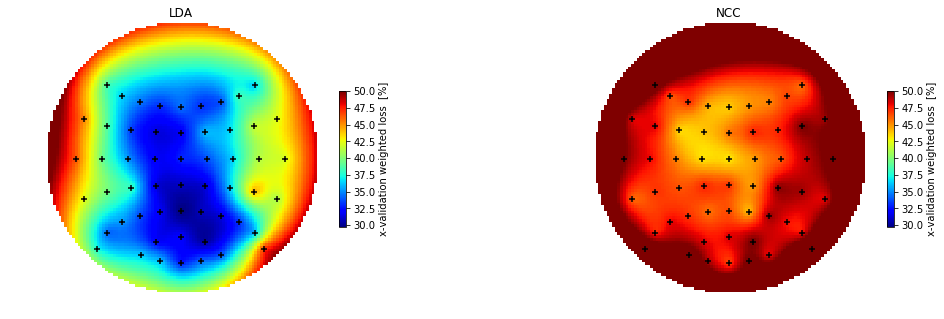

In [7]:
ival= [0, 1000]

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
nChans = epo.shape[1]

loss = np.zeros([nChans, 1])
loss_NCC = np.zeros([nChans, 1])
for ci in range(nChans):
    fv = epo[:, ci, :]
    loss[ci], _ = crossvalidation(train_LDA, fv, mrk_class)
    loss_NCC[ci], _ = crossvalidation(train_NCC, fv, mrk_class)

min_loss= np.vstack((loss, loss_NCC)).min()
plt.figure(figsize=[18, 5])
plt.subplot(1, 2, 1)
bci.scalpmap(mnt, loss, clim=(min_loss, 50), cb_label='x-validation weighted loss  [%]')
plt.title('LDA')
plt.subplot(1, 2, 2)
bci.scalpmap(mnt, loss_NCC, clim=(min_loss, 50), cb_label='x-validation weighted loss  [%]')
plt.title('NCC')
# still a bad classification 

## Exercise 5: Classification of Spatial Features  (4 points)
Perform classification (*target* vs. *nontarget*) on spatial features (average across time within a 50 ms interval) in a time window that is shifted from 0 to 1000 ms in steps of 10 ms, again with both, LDA and NCC. Visualize the time courses of the classification error. Again, use 10-fold cross-validation. Here, use a baseline correction w.r.t. the prestimulus interval -100 to 0 ms.

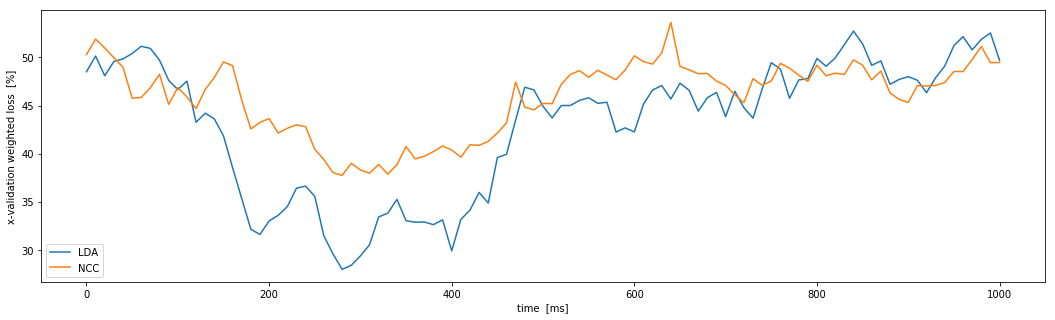

In [8]:
t_end= 1000
t_prestim= 100
win_size= 50;
win_step= 10;

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, [-t_prestim, t_end])
epo = bci.baseline(epo, epo_t, [-t_prestim, 0])

ival = np.array([-win_size, 0])
loss = []
loss_NCC = []
while ival[1] <= t_end:
    idx = (ival[0] <= epo_t) & (epo_t <= ival[1])
    fv = np.mean(epo[idx, :, :], axis=0)
    this_loss, _ = crossvalidation(train_LDA, fv, mrk_class)
    loss.append(this_loss)
    this_loss, _ = crossvalidation(train_NCC, fv, mrk_class)
    loss_NCC.append(this_loss)
    ival = ival + win_step

plt.figure(figsize=[18, 5])
plt.plot(np.linspace(0, t_end, len(loss)), loss, label='LDA')
plt.plot(np.linspace(0, t_end, len(loss_NCC)), loss_NCC, label='NCC')
plt.xlabel('time  [ms]')
plt.ylabel('x-validation weighted loss  [%]')
plt.legend()
# LDA is much better